# Autores
* Herber Sebastián Silva Muñoz - 21764
* Adrian Fulladolsa Palma - 21592
* Elías Alberto Alvarado Raxón - 21808

# Inciso 1
Implementar los algoritmos de Runge-Kutta (de orden 4) para resolver una EDO, y para resolver un sistema de EDO. Estos algoritmos se usarán en los siguientes problemas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.signal import find_peaks

In [2]:
def rk4_single(f, y0, t0, tf, h):
    t = np.arange(t0, tf + h, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    
    for i in range(1, len(t)):
        ti = t[i - 1]
        yi = y[i - 1]
        
        k1 = np.array(f(ti, yi))
        k2 = np.array(f(ti + h/2, yi + h * (k1/2)))
        k3 = np.array(f(ti + h/2, yi + h * (k2/2)))
        k4 = np.array(f(ti + h, yi + h * k3))
        
        y[i] = yi + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
    
    return t, y

In [3]:
def rk4_system(f, y0, t0, tf, h):
    n = int((tf - t0) / h)
    t = t0
    y = np.array(y0)
    results = [(t, y)]
    
    for _ in range(n):
        k1 = h * np.array(f(t, y))
        k2 = h * np.array(f(t + h/2, y + k1/2))
        k3 = h * np.array(f(t + h/2, y + k2/2))
        k4 = h * np.array(f(t + h, y + k3))
        
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        t = t + h
        results.append((t, y))
    
    return results

Implementación de función que grafica el campo vectorial o plano de fase para un sistema de EDO's

In [4]:
def plot_phase_plane(f, y_range, t_range, density=20):
    y1 = np.linspace(y_range[0], y_range[1], density)
    y2 = np.linspace(y_range[0], y_range[1], density)
    Y1, Y2 = np.meshgrid(y1, y2)
    
    U, V = np.zeros(Y1.shape), np.zeros(Y2.shape)
    
    for i in range(Y1.shape[0]):
        for j in range(Y1.shape[1]):
            t = 0
            y = [Y1[i, j], Y2[i, j]]
            dydt = f(t, y)
            U[i, j] = dydt[0]
            V[i, j] = dydt[1]
    
    plt.figure()
    plt.quiver(Y1, Y2, U, V, color='r')
    plt.streamplot(Y1, Y2, U, V, color='b')
    plt.xlabel('y1')
    plt.ylabel('y2')
    plt.title('Plano de Fase')
    plt.show()

Implementación de función clasificadora de puntos de equilibrio.

In [5]:
def classify_equilibrium_point(f, equilibrium_point):
    def jacobian(f, y, h=1e-5):
        n = len(y)
        J = np.zeros((n, n))
        f0 = np.array(f(0, y))
        for i in range(n):
            y1 = np.array(y, dtype=float)
            y1[i] += h
            fi = np.array(f(0, y1))
            J[:, i] = (fi - f0) / h
        return J
    
    J = jacobian(f, equilibrium_point)
    eigenvalues = np.linalg.eigvals(J)
    
    print("Punto de equilibrio:", equilibrium_point)
    print("Eigenvalores:", eigenvalues)
    
    if np.all(np.real(eigenvalues) < 0):
        if np.all(np.imag(eigenvalues) == 0):
            return "Nodo atractor"
        else:
            return "Espiral atractor"
    elif np.all(np.real(eigenvalues) > 0):
        if np.all(np.imag(eigenvalues) == 0):
            return "Nodo repulsor"
        else:
            return "Espiral repulsor"
    elif np.any(np.real(eigenvalues) < 0) and np.any(np.real(eigenvalues) > 0):
        if np.all(np.imag(eigenvalues) == 0):
            return "Punto silla"
        else:
            return "Espiral"
    elif np.any(np.real(eigenvalues) == 0) and np.any(np.imag(eigenvalues) == 0):
        return "Twist"
    else:
        return "Centro"

Implimentación para graficar los resultados de Runge-Kutta

In [6]:
def plot_rk4_results(result, title="Resultados del sistema de ecuaciones diferenciales"):
    t_values = [t for t, y in result]
    solutions = list(zip(*[y for t, y in result]))

    plt.figure(figsize=(10, 6))
    for i, solution in enumerate(solutions):
        plt.plot(t_values, solution, label=f'Solución {i+1}')
    
    plt.title(title)
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid(True)
    plt.show()

Implementación para estimar población y período

In [7]:
def estimate_population_and_period(result, years=5):
    t_values = [t for t, y in result]
    solutions = list(zip(*[y for t, y in result]))
    
    final_time = t_values[-1]
    target_time = years
    closest_index = np.argmin(np.abs(np.array(t_values) - target_time))
    population_estimate = {
        'x': solutions[0][closest_index],
        'y': solutions[1][closest_index]
    }
    
    x_values = solutions[0]
    y_values = solutions[1]
    
    def find_period(values):
        peaks = [i for i in range(1, len(values)-1) if values[i-1] < values[i] > values[i+1]]
        if len(peaks) > 1:
            periods = [t_values[peaks[i+1]] - t_values[peaks[i]] for i in range(len(peaks)-1)]
            return np.mean(periods)
        return None
    
    period_x = find_period(x_values)
    period_y = find_period(y_values)
    
    period = {
        'x': period_x,
        'y': period_y
    }
    
    return population_estimate, period

Implementación para imprimir el plano de fase con las trayectorias del resultado y el campo vectorial

In [8]:
def plot_phase_plane_with_trajectories(f, result, y_range, t_range, years=5, density=20):
    y1 = np.linspace(y_range[0], y_range[1], density)
    y2 = np.linspace(y_range[0], y_range[1], density)
    Y1, Y2 = np.meshgrid(y1, y2)
    
    U, V = np.zeros(Y1.shape), np.zeros(Y2.shape)
    
    for i in range(Y1.shape[0]):
        for j in range(Y1.shape[1]):
            t = 0
            y = [Y1[i, j], Y2[i, j]]
            dydt = f(t, y)
            U[i, j] = dydt[0]
            V[i, j] = dydt[1]
    
    plt.figure(figsize=(10, 6))
    plt.quiver(Y1, Y2, U, V, color='gray')
    plt.streamplot(Y1, Y2, U, V, color='lightgray')
    
    t_values = [t for t, y in result]
    x_values = [y[0] for t, y in result]
    y_values = [y[1] for t, y in result]
    
    plt.plot(x_values, y_values, label='Trayectoria', color='blue')
    
    closest_index = np.argmin(np.abs(np.array(t_values) - years))
    plt.scatter(x_values[0], y_values[0], color='green', label='Población inicial', zorder=5)
    plt.scatter(x_values[closest_index], y_values[closest_index], color='red', label='Población final a los 5 años', zorder=5)
    
    plt.xlabel('x (Población de la especie x)')
    plt.ylabel('y (Población de la especie y)')
    plt.title('Plano de Fase con Trayectorias y Campo Vectorial')
    plt.legend()
    plt.grid(True)
    plt.show()

Implementación para graficar en 3d

In [9]:
def plot_trajectory_3d(t, y, elev=30, azim=30):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(y[:, 0], y[:, 1], y[:, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Trayectoria completa en 3D')

    ax.view_init(elev=elev, azim=azim)

    plt.show()

Implementación para graficar las proyecciones en 3d por separado

In [10]:
def plot_projections(t, y):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].plot(y[:, 0], y[:, 1])
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].set_title('Proyección xy')
    
    axs[1].plot(y[:, 0], y[:, 2])
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('z')
    axs[1].set_title('Proyección xz')
    
    axs[2].plot(y[:, 1], y[:, 2])
    axs[2].set_xlabel('y')
    axs[2].set_ylabel('z')
    axs[2].set_title('Proyección yz')

    plt.tight_layout()
    plt.show()

Implementación para graficar $r(t)$ en función de $t$

In [11]:
def plot_distance_vs_time(t_sol, y_sol):
    r_t = np.sqrt(y_sol[:, 0]**2 + y_sol[:, 1]**2 + y_sol[:, 2]**2)
    
    plt.figure(figsize=(10, 6))
    plt.plot(t_sol, r_t)
    plt.xlabel('Tiempo (años)')
    plt.ylabel('Distancia r(t) (UA)')
    plt.title('Distancia del Cometa Halley al Sol en función del tiempo')
    plt.grid(True)
    plt.show()

Implementación para estimar el período de los ciclos de repetición del cometa

In [12]:
def estimate_period(t_sol, y_sol):
    r_t = np.sqrt(y_sol[:, 0]**2 + y_sol[:, 1]**2 + y_sol[:, 2]**2)
    peaks, _ = find_peaks(r_t)
    periods = np.diff(t_sol[peaks])
    average_period = np.mean(periods)
    return average_period

# Inciso 2

Dos poblaciones de animales $x(t)$ y $y(t)$ satisfacen el siguiente sistema de EDO:

$$
x'(t) = 0.2x - 0.005xy \\
y'(t) = -0.5y + 0.01xy
$$

In [13]:
def predator_prey_system(t, y):
    x, y = y
    dxdt = 0.2 * x - 0.005 * x * y
    dydt = -0.5 * y + 0.01 * x * y
    return [dxdt, dydt]

Aquí, la escala de tiempo se mide en meses.
Nos interesa la trayectoria y el campo de direcciones que este sistema forma en el primer cuadrante del plano $xy$ (ya que $x(t)$, $y(t)$ son ambas cantidades de individuos, sólo tiene sentido cuando estas son cantidades no-negativas). Resolver lo siguiente:

**a)** Grafique el campo vectorial o plano de fase asociado a ese sistema de EDO

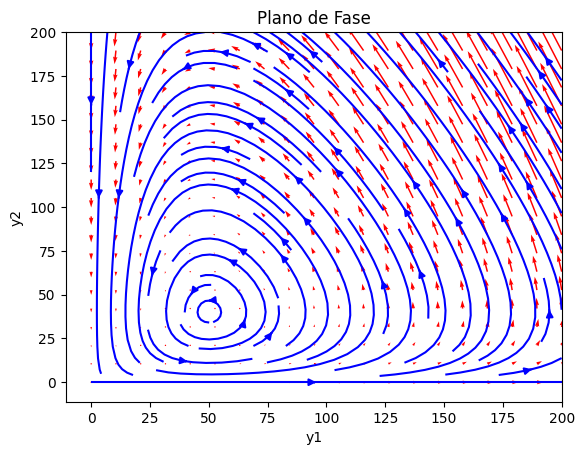

In [14]:
plot_phase_plane(predator_prey_system, [0, 200], [0, 200])

**b)** Usando algoritmos computacionales, encuentre todos los puntos de equilibrio del sistema de EDO (sólo los que están en el primer cuadrante, incluyendo los ejes y el origen), y clasificarlos de acuerdo a su comportamiento. Explique cualitativamente cómo se comportan las soluciones cerca del punto de equilibrio obtenido.

Declaración de función envoltura para obtener los puntos de equilibrio:

In [15]:
def predator_prey_system_wrapper(y):
    return predator_prey_system(0, y)

Definición de varios puntos inciales:

In [16]:
puntos_iniciales = [
    [1, 1],
    [40, 50],
    [1000, 1000],
    [2000, 1000],
    [1000, 2000],
    [2000, 2000]
]

In [17]:
puntos_de_equilibrio = set()
for punto in puntos_iniciales:
    punto_de_equilibrio = fsolve(predator_prey_system_wrapper, punto)
    puntos_de_equilibrio.add(tuple(np.round(punto_de_equilibrio, 2)))

print("Puntos de equilibrio:")
for punto in puntos_de_equilibrio:
    print(f"(x: {punto[0]}, y: {punto[1]})")

Puntos de equilibrio:
(x: 50.0, y: 40.0)
(x: -0.0, y: 0.0)


Clasificación de puntos de equilibrio

In [18]:
for punto in puntos_de_equilibrio:
    clasificacion = classify_equilibrium_point(predator_prey_system, punto)
    print(f"Clasificación del punto de equilibrio {punto}: {clasificacion}")
    print("") 

Punto de equilibrio: (50.0, 40.0)
Eigenvalores: [0.+0.31622777j 0.-0.31622777j]
Clasificación del punto de equilibrio (50.0, 40.0): Centro

Punto de equilibrio: (-0.0, 0.0)
Eigenvalores: [ 0.2 -0.5]
Clasificación del punto de equilibrio (-0.0, 0.0): Punto silla



**c)** Resuelva el sistema de EDO, con su algoritmo Runge-Kutta, para la condición incial
$$x(0) = 70, \ \ \ \ y(0) = 30$$

Se definen las condiciones iniciales

In [19]:
z0 = np.array([70, 30])
t0 = 0
tf = 100
h = 0.01

Se resuelve el sistema

In [20]:
result_1 = rk4_system(predator_prey_system, z0, t0, tf, h)

Obtenga una gráfica de la solución obtenida, y estime cuál será la población para las especies $x$ y $y$ después de 5 años. Aproxime cuál es el valor del período o ciclo de repetición de las poblaciones.

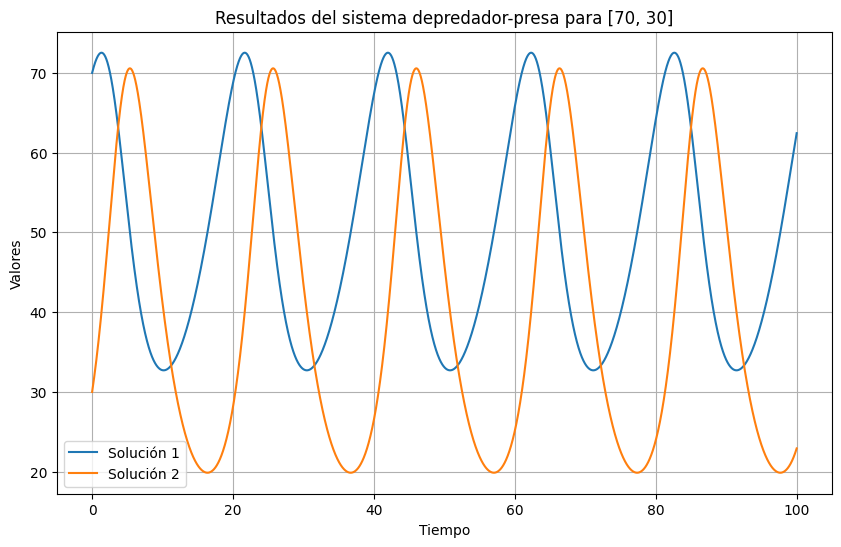

In [21]:
plot_rk4_results(result_1, title="Resultados del sistema depredador-presa para [70, 30]")

Estimación de las especies $x$ y $y$ después de 5 años, incluyendo período

In [22]:
population_estimate, period = estimate_population_and_period(result_1, years=5)
print(f"Población estimada después de 5 años: {population_estimate}")
print(f"Período aproximado de las poblaciones: {period}")

Población estimada después de 5 años: {'x': 52.80790505748697, 'y': 70.21578685011013}
Período aproximado de las poblaciones: {'x': 20.327500000001343, 'y': 20.327500000001876}


**d)** Repita la solución del sistema de EDO, esta vez para la condición inicial
$$
x(0) = 100, \ \ \ \ y(0) = 10
$$

Se definen las condiciones iniciales

In [23]:
z0 = np.array([100, 10])
t0 = 0
tf = 100
h = 0.01

Se resuelve el sistema

In [24]:
result_2 = rk4_system(predator_prey_system, z0, t0, tf, h)

Obtenga una gráfica de la solución obtenida, y estime cuál será la población para las especies $x$ y $y$ después de 5 años. Aproxime cuál es el valor del período o ciclo de repetición de las poblaciones.

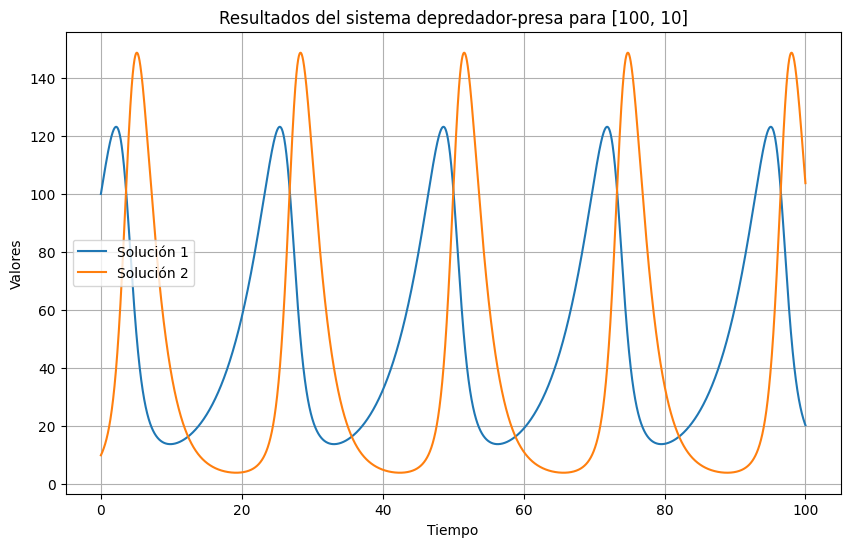

In [25]:
plot_rk4_results(result_2, title="Resultados del sistema depredador-presa para [100, 10]")

Estimación de las especies $x$ y $y$ después de 5 años, incluyendo período

In [26]:
population_estimate, period = estimate_population_and_period(result_2, years=5)
print(f"Población estimada después de 5 años: {population_estimate}")
print(f"Período aproximado de las poblaciones: {period}")

Población estimada después de 5 años: {'x': 52.910149502912745, 'y': 148.42087698065714}
Período aproximado de las poblaciones: {'x': 23.232500000002936, 'y': 23.23250000000333}


**e)** Grafique ambas trayectorias obtenidas en su plano de fase $xy$ (encima del campo vectorial). Ilustre en la gráfica el valor de la población inicial y final (a los 5 años) en cada caso.

Trayectorias con [70, 30]

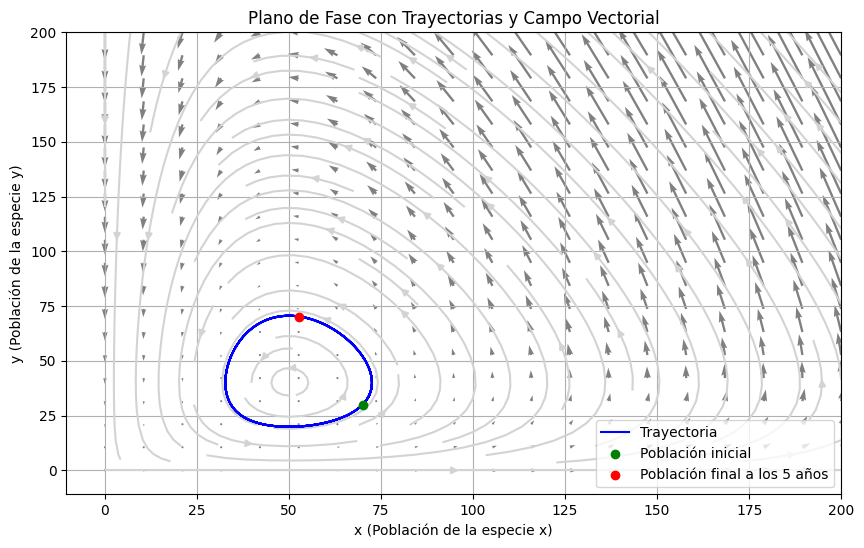

In [27]:
plot_phase_plane_with_trajectories(predator_prey_system, result_1, y_range=[0, 200], t_range=[0, 200], years=5, density=20)

Trayectorias con [100, 10]

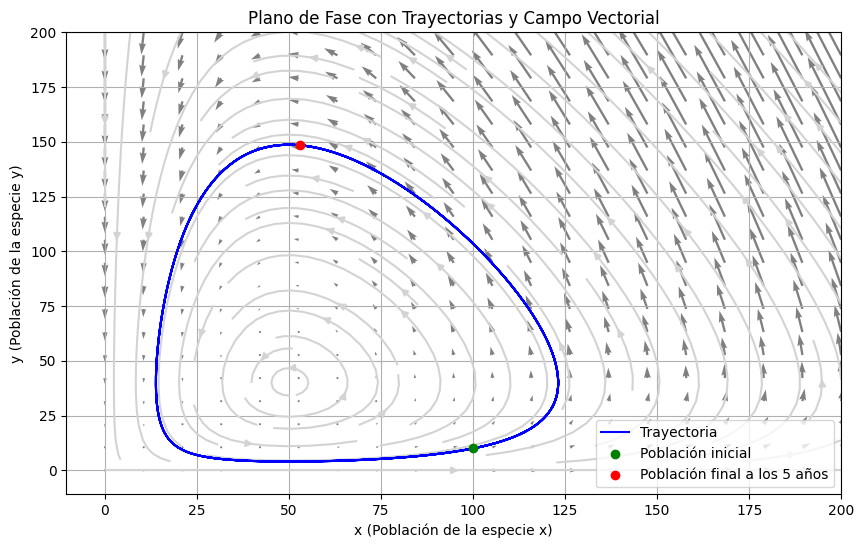

In [28]:
plot_phase_plane_with_trajectories(predator_prey_system, result_2, y_range=[0, 200], t_range=[0, 200], years=5, density=20)

**f)** Explique o describa cualitativamente el comportamiento del sistema de poblaciones

El sistema de ecuaciones diferenciales dado describe la interacción entre dos especies en un modelo depredador-presa. Las ecuaciones son:


$$
x'(t) = 0.2x - 0.005xy \\
y'(t) = -0.5y + 0.01xy
$$


Donde:
- $x(t)$ representa la población de la especie presa.
- $y(t)$ representa la población de la especie depredadora.

### Comportamiento cualitativo:

1. **Crecimiento de la presa en ausencia de depredadores**:
   - La ecuación $x'(t) = 0.2x$ indica que, en ausencia de depredadores $y = 0$, la población de presas crece exponencialmente a una tasa del 20% por unidad de tiempo.

2. **Disminución de la depredadora en ausencia de presas**:
   - La ecuación $y'(t) = -0.5y$ indica que, en ausencia de presas $x = 0$, la población de depredadores disminuye exponencialmente a una tasa del 50% por unidad de tiempo.

3. **Interacción depredador-presa**:
   - El término $-0.005xy$ en la ecuación de $x'(t)$ representa la disminución de la población de presas debido a la depredación. La tasa de disminución es proporcional al producto de las poblaciones de presas y depredadores.
   - El término $0.01xy$ en la ecuación de $y'(t)$ representa el aumento de la población de depredadores debido a la disponibilidad de presas. La tasa de aumento es proporcional al producto de las poblaciones de presas y depredadores.

### Dinámica del sistema:

- **Oscilaciones**:
  - El sistema tiende a mostrar oscilaciones periódicas en las poblaciones de ambas especies. Cuando la población de presas es alta, la población de depredadores aumenta debido a la abundancia de alimento. Sin embargo, a medida que la población de depredadores crece, la población de presas disminuye debido a la mayor depredación. Esto, a su vez, causa una disminución en la población de depredadores debido a la falta de alimento, permitiendo que la población de presas se recupere y el ciclo se repita.

- **Equilibrio**:
  - El sistema puede alcanzar un punto de equilibrio donde las poblaciones de ambas se llegan a estabilizar, dicho de otra forma en el centro.

# Inciso 3
Suponga ahora que las poblaciones de dos especies $x(t)$ y $y(t)$ satisfacen el sistema de EDO:
$$
x'(t) = 0.5x - 0.011x^2 -xy, \\
y'(t) = -0.2y + 0.1xy
$$

In [29]:
def new_predator_prey_system(t, y):
    x, y = y
    dxdt = 0.5 * x - 0.011 * x**2 - x * y
    dydt = -0.2 * y + 0.1 * x * y
    return [dxdt, dydt]

La escala de tiempo de nuevo se mide en meses.
Nos interesa la trayectoria y el campo de direcciones que este sistema forma en el primer cuadrante del plano $xy$ (ya que $x(t)$, $y(t)$ son ambas cantidades de individuos, sólo tiene sentido cuando estas son cantidades no-negativas). Resolver lo siguiente:

**a)** Grafique el campo vectorial o plano asociado a ese sistema de EDO.

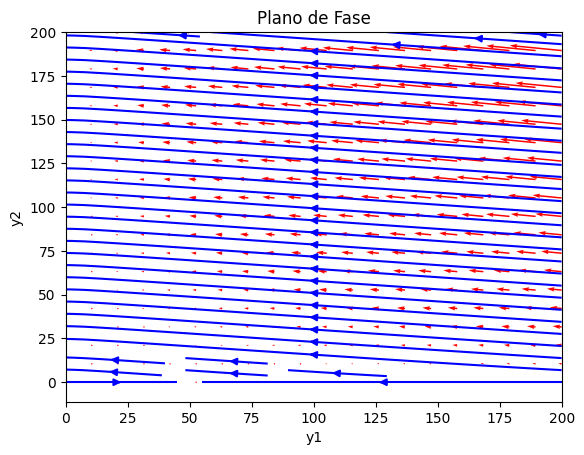

In [30]:
plot_phase_plane(new_predator_prey_system, [0, 200], [0, 200])

**b)** Usando algoritmos computacionales, encuentre todos los puntos de equilibrio del sistema de EDO (sólo los que están en el primer cuadrante, incluyendo los ejes y el origen). Y clasificarlos de acuerdo a su comportamiento. Explique cualitativamente cómo se comporatn las soluciones cerca del punto de equilibrio obtenido.

Declaración de función de envoltura para obtener los puntos de equilibrio:

In [31]:
def new_predator_prey_system_wrapper(y):
    return new_predator_prey_system(0, y)

Definición de puntos iniciales

In [32]:
puntos_iniciales_2 = [
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
    [50, 50],
    [100, 100],
    [500, 500],
    [500, 10],
    [1000, 2000],
    [2000, 1000],
    [2000, 2000]
]

In [33]:
puntos_de_equilibrio_2 = set()
for punto in puntos_iniciales_2:
    punto_de_equilibrio = fsolve(new_predator_prey_system_wrapper, punto)
    puntos_de_equilibrio_2.add(tuple(np.round(punto_de_equilibrio, 2)))

print("Puntos de equilibrio:")
for punto in puntos_de_equilibrio_2:
    print(f"(x: {punto[0]}, y: {punto[1]})")

Puntos de equilibrio:
(x: 45.45, y: 0.0)
(x: 2.0, y: 0.48)
(x: 0.0, y: 0.0)


Clasificación de Puntos de Equilibrio:

In [34]:
for punto in puntos_de_equilibrio_2:
    clasificacion = classify_equilibrium_point(new_predator_prey_system, punto)
    print(f"Clasificación del punto de equilibrio {punto}: {clasificacion}")
    print("") 

Punto de equilibrio: (45.45, 0.0)
Eigenvalores: [-0.49990011  4.345     ]
Clasificación del punto de equilibrio (45.45, 0.0): Punto silla

Punto de equilibrio: (2.0, 0.48)
Eigenvalores: [-0.01200005+0.3096062j -0.01200005-0.3096062j]
Clasificación del punto de equilibrio (2.0, 0.48): Espiral atractor

Punto de equilibrio: (0.0, 0.0)
Eigenvalores: [ 0.49999989 -0.2       ]
Clasificación del punto de equilibrio (0.0, 0.0): Punto silla



En torno a $(0, 0)$ el sistema tiene un punto silla, por lo tanto se muestra una repulsión y atracción hacia varias direcciones, lo mismo sucede con el punto $(45.45, 0)$. Por otro lado, en el espiral atractor, es decir $(2.0, 0.48)$, se dice que el sistema muestra oscilaciones, ciclos y períodos. Esta es una naturaleza del punto en sí.

**c)** Resuelva el sistema de EDO, con su algoritmo de Runge-Kutta, para la condición inicial:

$$
x(0) = 10, \ \ \ \ y(0) = 10
$$

Se definen las condiciones iniciales

In [35]:
z0 = np.array([10, 10])
t0 = 0
tf = 100
h = 0.01

Se resuelve el sistema

In [36]:
result_3 = rk4_system(new_predator_prey_system, z0, t0, tf, h)

Obtenga una gráfica de la solución obtenida, y estime cuál será la población para las especies $x$ y $y$ después de 5 años.

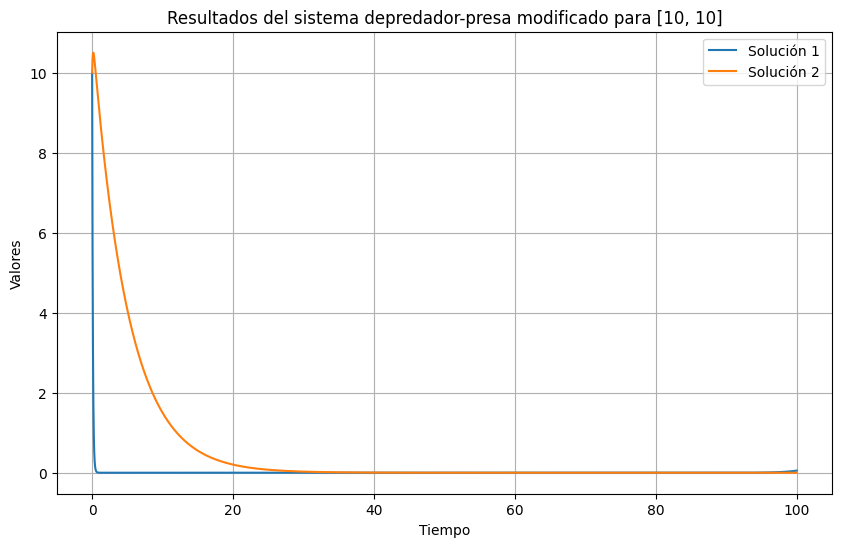

In [37]:
plot_rk4_results(result_3, title="Resultados del sistema depredador-presa modificado para [10, 10]")

Estimación de las especies $x$ y $y$ después de 5 años

In [38]:
population_estimate, _ = estimate_population_and_period(result_3, years=5)
print(f"Población estimada después de 5 años: {population_estimate}")

Población estimada después de 5 años: {'x': 8.657412009843227e-14, 'y': 4.071232295990503}


**d)** Grafique ambas trayectorias obtenidas en su plano de fase $xy$ (encima del campo vectorial). Ilustre en la gráfica el valor de la población inicial y final (a los 5 años) en cada caso.

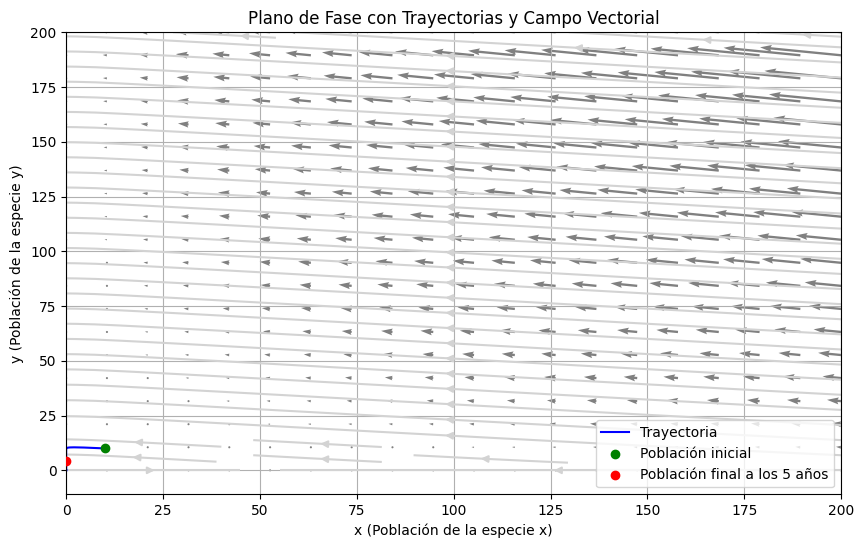

In [39]:
plot_phase_plane_with_trajectories(new_predator_prey_system, result_3, y_range=[0, 200], t_range=[0, 200], years=5, density=20)

**f)** Explique o describa cualitativamente el comportamiento del sistema de poblaciones

El sistema de ecuaciones diferenciales dado describe la interacción entre dos especies en un modelo depredador-presa. Las ecuaciones son:

$$
x'(t) = 0.5x - 0.011x^2 - xy \\
y'(t) = -0.2y + 0.1xy
$$

Donde:
- $x(t)$ representa la población de la especie presa.
- $y(t)$ representa la población de la especie depredadora.

### Comportamiento cualitativo:

1. **Crecimiento de la presa en ausencia de depredadores**:
   - La ecuación $x'(t) = 0.5x - 0.011x^2$ indica que, en ausencia de depredadores $y = 0$, la población de presas crece inicialmente a una tasa del 50% por unidad de tiempo, pero este crecimiento se ve limitado por el término $-0.011x^2$, que representa la competencia intraespecífica.

2. **Disminución de la depredadora en ausencia de presas**:
   - La ecuación $y'(t) = -0.2y$ indica que, en ausencia de presas $x = 0$, la población de depredadores disminuye exponencialmente a una tasa del 20% por unidad de tiempo.

3. **Interacción depredador-presa**:
   - El término $-xy$ en la ecuación de $x'(t)$ representa la disminución de la población de presas debido a la depredación. La tasa de disminución es proporcional al producto de las poblaciones de presas y depredadores.
   - El término $0.1xy$ en la ecuación de $y'(t)$ representa el aumento de la población de depredadores debido a la disponibilidad de presas. La tasa de aumento es proporcional al producto de las poblaciones de presas y depredadores.

### Dinámica del sistema:

- **Oscilaciones**:
  - El sistema en este caso no presenta oscilaciones puesto que los puntos críticos que delimitan dos rangos del infinito se comportan de forma que tienden hacia este, al infinito, que da como resultado la extinción de depredadores u presas, según sea, esto por los puntos silla.

- **Equilibrio**:
  - El sistema se mantiene equilibrado una vez esté rondando el punto crítico del espiral atractor, en el cual tanto depredadores como presas se mantendrán estables.

# Inciso 4
El cometa Halley alcanzó el último perihelio (su punto de acercamiento más cercano al Sol, el Sol en el origen) el 9 de febrero de 1986. Sus comportamientos de posición y velocidad en ese momento fueron:

$$
p_0 = (0.325514, -0.459460, 0.166229), \ \ v_0 (-9.096111, -6.916686, -1.305721)
$$

respectivamente. Aquí la posición se mide en $UA$ (unidades astronómicas), en las cuales la unidad de distancia corresponde al semi-eje mayor del planeta Tierra, y el tiempo se mide en años. El vector $p(t)$ describe la posición $p(t) = (x(t), y(t), z(t))$ del cometa.

Las ecuaciones de movimiento del cometa son

$$
\frac{d^2x}{dt^2} = -\frac{\mu x}{r^3}, \ \ \ \ \frac{d^2y}{dt^2} = -\frac{\mu y}{r^3}, \ \ \ \ \frac{d^2z}{dt^2} = -\frac{\mu z}{r^3}
$$

donde $\mu = 4\pi^2$ y $r = \sqrt{x^2 + y^2 + z^2}$

Definición de constantes

In [40]:
mu = 4 * np.pi**2

Definición de la trayectoria del cometa

In [41]:
def comet_trajectory(t, state):
    x, y, z, vx, vy, vz = state
    r = np.sqrt(x**2 + y**2 + z**2)
    dxdt = vx
    dydt = vy
    dzdt = vz
    dvxdt = -mu * x / r**3
    dvydt = -mu * y / r**3
    dvzdt = -mu * z / r**3
    return [dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt]

Definición de condiciones iniciales

In [42]:
p0 = np.array([0.325514, -0.459460, 0.166229])
v0 = np.array([-9.096111, -6.916686, -1.305721])
initial_conditions = np.concatenate([p0, v0])

**a)** Resolver las ecuaciones mediante algoritmos numéricos. Graficar las proyecciones $xy$, $xz$ y $xz$ de la trayectoria del cometa (si lo desea, puede graficar una trayectoria completa mediante una gráfica 3D)

In [43]:
z0 = initial_conditions
t0 = 0
tf = 100
h = 0.01

t_sol, y_sol = rk4_single(comet_trajectory, z0, t0, tf, h)

Proyecciones por separado

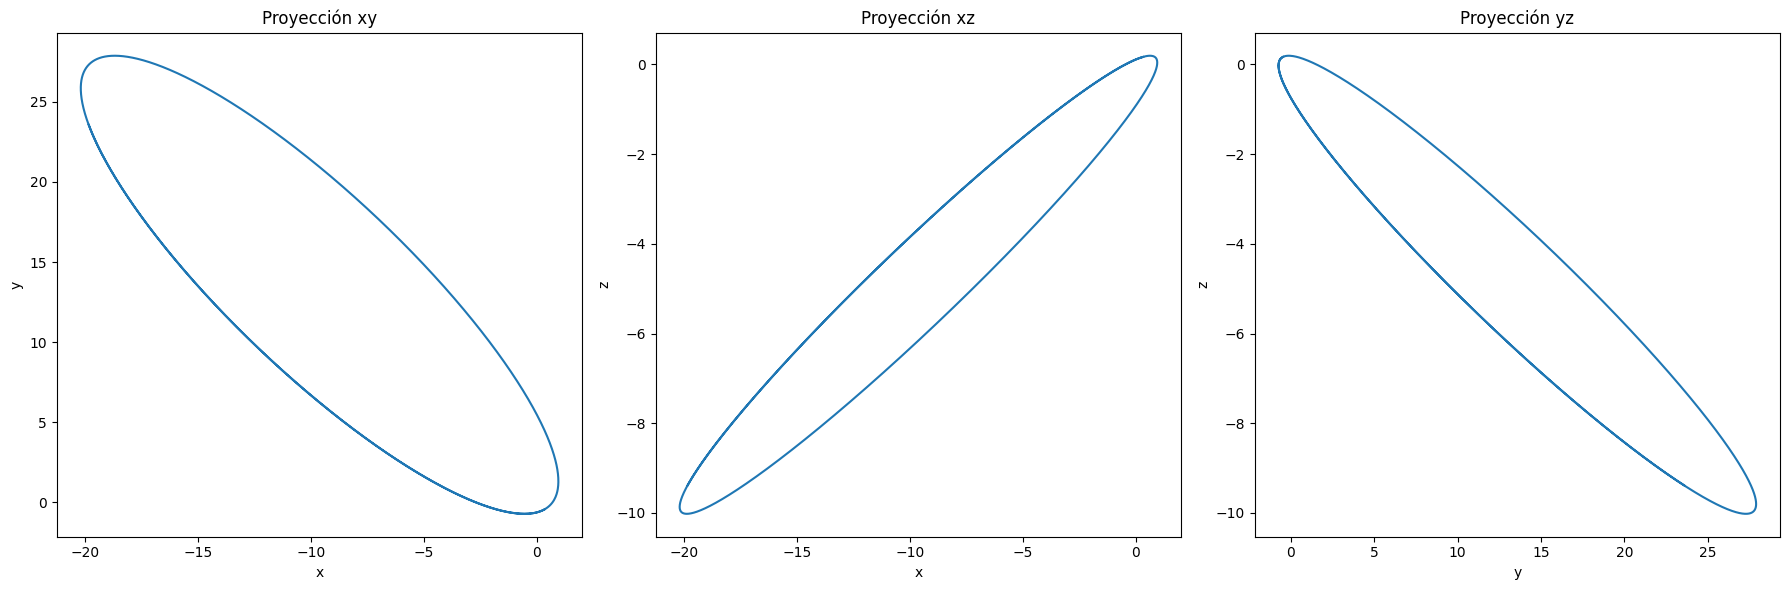

In [44]:
plot_projections(t_sol, y_sol)

Proyecciones en 3d

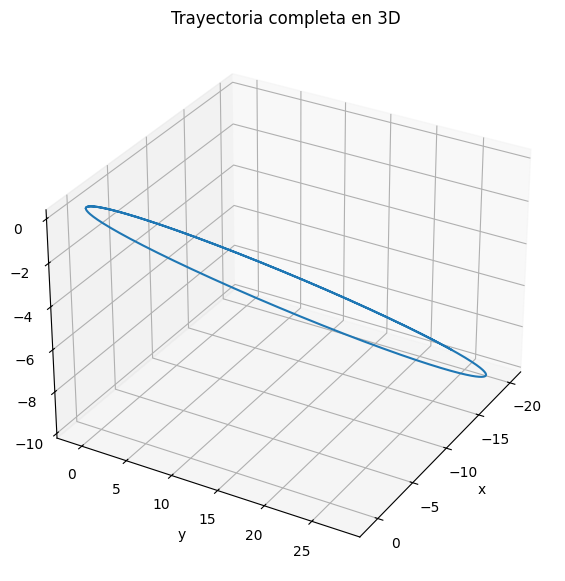

In [45]:
plot_trajectory_3d(t_sol, y_sol)

**b)** Estimar la posición y velocidad del cometa para el 9 de febrero de 2086, y de 2186 ($t=100$ y $200$ años)

Estimación para el 9 de febrero de 2086

In [46]:
tf = 300
h = 0.01
t_sol, y_sol = rk4_single(comet_trajectory, z0, t0, tf, h)

position = y_sol[np.where(t_sol == 100)[0][0], :3]
velocity = y_sol[np.where(t_sol == 100)[0][0], 3:]

print(f"Posición final del cometa: {position}")
print(f"Velocidad final del cometa: {velocity}")

Posición final del cometa: [-19.84490276  23.56364952  -9.38239428]
Velocidad final del cometa: [-0.12434545  0.47169782 -0.11356382]


Estimación para el 9 de febrero de 2186

In [47]:
position = y_sol[np.where(t_sol == 200)[0][0], :3]
velocity = y_sol[np.where(t_sol == 200)[0][0], 3:]

print(f"Posición final del cometa: {position}")
print(f"Velocidad final del cometa: {velocity}")

Posición final del cometa: [-17.15490663  27.47483738  -9.31161824]
Velocidad final del cometa: [ 0.32643984 -0.14795328  0.11382631]


**c)** Elaborar una gráfica de $t$ y $r(t)$ y estimar el período de repetición de los ciclos del cometa.

Gráfica $t$ vs $r(t)$

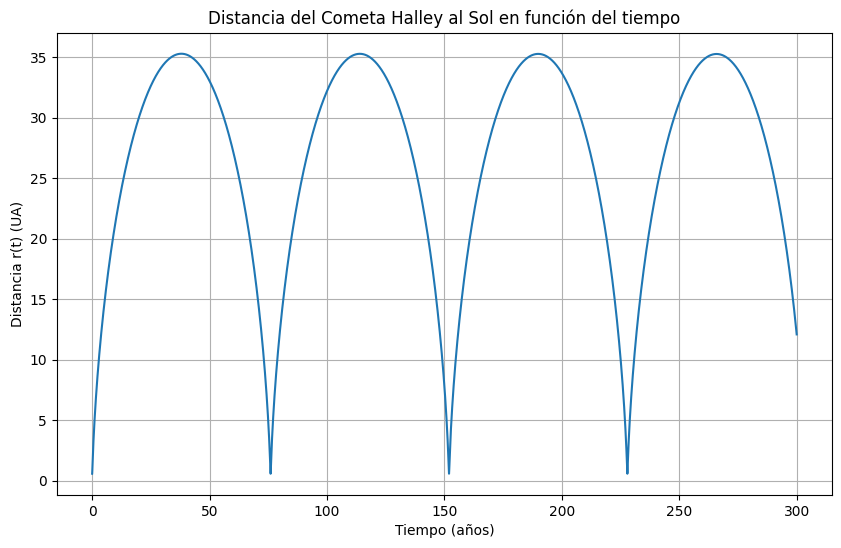

In [48]:
plot_distance_vs_time(t_sol, y_sol)

Estimación de período de los ciclos del cometa

In [49]:
average_period = estimate_period(t_sol, y_sol)
print(f"Período promedio de la órbita del cometa: {average_period} años")

Período promedio de la órbita del cometa: 75.95666666666666 años
